In [1]:
#import relevant packages
from netCDF4 import Dataset
import os
import datetime
import xarray as xr
import xradar as xd
import act
import matplotlib.pyplot as plt
import cmweather
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
import glob

from statsmodels.tsa.stattools import acf
%matplotlib inline

In [16]:
def get_variances(input_ds):
    dt_range = pd.date_range(input_ds['time'].values[0], input_ds['time'].values[-1], periods=
                         int((input_ds['time'].values[-1] - input_ds['time'].values[0])/0.5e9))
    nperiods = len(dt_range)
    print(nperiods)
    inp_ds = input_ds.reindex(time=dt_range, method='nearest', tolerance=np.timedelta64(1, 's'))
    
    time_10min = inp_ds["time"].resample(time="10min").min().values
    noise_variance = np.zeros((time_10min.shape[0], len(inp_ds['range'])))
    atmos_variance = np.zeros_like(noise_variance)
    w_25 = np.zeros_like(noise_variance)
    w_50 = np.zeros_like(noise_variance)
    w_75 = np.zeros_like(noise_variance)
    w_min = np.zeros_like(w_25)
    w_max = np.zeros_like(w_min)
    variance = np.zeros_like(noise_variance)
    for i, j in enumerate(range(0, nperiods, 1200)):
        for k in range(0, len(inp_ds['range'])):
            series = inp_ds['radial_velocity'].values[j:min([j+3600, nperiods]), k]
            series_intensity = inp_ds['intensity'].values[j:min([j+3600, nperiods])]
            series = series[np.isfinite(series)]
            if len(series) == 0:
                continue
            try:
                v_acf = acf(series, nlags=5)
            except ValueError:
                variance[i, k] = np.nan
                noise_variance[i, k] = np.nan
                atmos_variance[i, k] = np.nan
                w_25[i, k] = np.nan
                w_50[i, k] = np.nan
                w_75[i, k] = np.nan
                w_min[i, k] = np.min(series)
                w_max[i, k] = np.max(series)
                continue
            variance[i, k] = np.var(series)
            noise_variance[i, k] = (v_acf[0] - v_acf[1]) * variance[i, k]
            atmos_variance[i, k] = variance[i, k] - noise_variance[i, k]
            w_25[i, k] = np.percentile(series, 0.25)
            w_50[i, k] = np.percentile(series, 0.5)
            w_75[i, k] = np.percentile(series, 0.75)
            w_min[i, k] = np.min(series)
            w_max[i, k] = np.max(series)
    variance = xr.DataArray(variance, dims=["time", "range"])
    variance.attrs["long_name"] = "Total variance"
    variance.attrs["units"] = "m s-1"
    noise_variance = xr.DataArray(noise_variance, dims=["time", "range"])
    noise_variance.attrs["long_name"] = "Variance due to noise"
    noise_variance.attrs["units"] = "m s-1"
    atmos_variance = xr.DataArray(atmos_variance, dims=["time", "range"])
    atmos_variance.attrs["long_name"] = "Variance due to signal"
    atmos_variance.attrs["units"] = "m s-1"
    w_25 = xr.DataArray(w_25, dims=["time", "range"])
    w_25.attrs["long_name"] = "25th percentile of w"
    w_25.attrs["units"] = "m s-1"
    w_50 = xr.DataArray(w_50, dims=["time", "range"])
    w_50.attrs["long_name"] = "50th percentile of w"
    w_50.attrs["units"] = "m s-1"
    w_75 = xr.DataArray(w_75, dims=["time", "range"])
    w_75.attrs["long_name"] = "75th percentile of w"
    w_75.attrs["units"] = "m s-1"
    w_min = xr.DataArray(w_min, dims=["time", "range"])
    w_min.attrs["long_name"] = "Minimum w"
    w_min.attrs["units"] = "m s-1"
    w_max = xr.DataArray(w_max, dims=["time", "range"])
    w_max.attrs["long_name"] = "Maximum w"
    w_max.attrs["units"] = "m s-1"
    
    variance_ds = xr.Dataset({'time': time_10min,
                              'range': inp_ds["range"],
                              'variance': variance,
                              'noise_variance': noise_variance,
                              'atmos_variance': atmos_variance,
                              'w_25': w_25, 'w_min': w_min,
                              'w_50': w_50, 'w_max': w_max,
                              'w_75': w_75})

    return variance_ds


In [18]:
stares = xr.open_mfdataset('20240722/*Stare*.nc', combine='nested', concat_dim='time', parallel=True).sortby('time').load()

In [19]:
variance_ds = get_variances(stares)
variance_ds.to_netcdf('20240722/variance_stare_10min.nc', mode='w', format='NETCDF4')  # Save the variance dataset to a netCDF file

172798


/Users/celsloaner/miniforge3/envs/my_env/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [2]:
variance_ds = xr.open_dataset('20240722/variance_stare_10min.nc')  # Load the saved variance dataset
print(variance_ds)  # Print the dataset to verify its contents

<xarray.Dataset> Size: 3MB
Dimensions:         (time: 144, range: 300)
Coordinates:
  * time            (time) datetime64[ns] 1kB 2024-07-22T00:00:00.420012 ... ...
  * range           (range) float64 2kB 15.0 45.0 75.0 ... 8.955e+03 8.985e+03
Data variables:
    variance        (time, range) float64 346kB ...
    noise_variance  (time, range) float64 346kB ...
    atmos_variance  (time, range) float64 346kB ...
    w_25            (time, range) float64 346kB ...
    w_min           (time, range) float64 346kB ...
    w_50            (time, range) float64 346kB ...
    w_max           (time, range) float64 346kB ...
    w_75            (time, range) float64 346kB ...


In [22]:
vads = xr.open_mfdataset('20240722/*VAD*.nc', combine='nested', concat_dim='time', parallel=True).sortby('time').load()
vad_ds = act.retrievals.compute_winds_from_ppi(vads)
vad_ds.to_netcdf('20240722/vad_winds_10min.nc', mode='w', format='NETCDF4')  # Save the VAD winds dataset to a

In [4]:
vad_ds = xr.open_dataset('20240722/vad_winds_10min.nc')  # Load the saved VAD winds dataset
print(vad_ds)  # Print the dataset to verify its contents

<xarray.Dataset> Size: 2MB
Dimensions:                (time: 125, height: 300)
Coordinates:
  * time                   (time) datetime64[ns] 1kB 2024-07-22T11:54:58.5649...
  * height                 (height) float64 2kB 9.642 28.93 ... 5.775e+03
Data variables:
    wind_speed             (time, height) float64 300kB ...
    wind_direction         (time, height) float64 300kB ...
    wind_speed_error       (time, height) float64 300kB ...
    wind_direction_error   (time, height) float64 300kB ...
    signal_to_noise_ratio  (time, height) float64 300kB ...
    residual               (time, height) float64 300kB ...
    correlation            (time, height) float64 300kB ...


In [38]:
hsrl = xr.open_dataset('/Users/celsloaner/Downloads/gvhsrl_day_20240722T0000_20240723T0000_30s_30m.nc')
hsrl["altitude"] = hsrl["altitude"] - hsrl.attrs["hsrl_altitude_m"]

/Users/celsloaner/miniforge3/envs/my_env/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


(0.0, 3000.0)

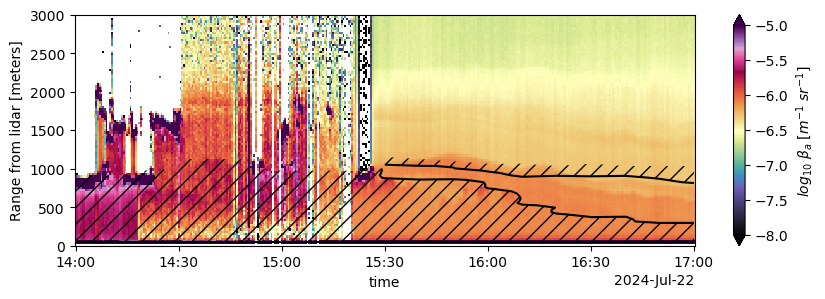

In [40]:
start_time = '2024-07-22T14:00:00'
end_time = '2024-07-22T17:00:00'
plt.figure(figsize=(10, 3))
np.log10(hsrl["atten_beta_a_backscat"]).sel(time=slice(start_time, end_time)).T.plot(
    vmin=-8, vmax=-5, cmap='ChaseSpectral', cbar_kwargs={'label': '$log_{10}$ $\\beta_{a}$ [$m^{-1}$ $sr^{-1}$]'})
variance_ds['atmos_variance'].where(
    variance_ds['noise_variance'] < 1).sel(time=slice(start_time, end_time)).T.plot.contour(levels=[0.04], colors='black')
variance_ds['atmos_variance'].where(
    variance_ds['noise_variance'] < 1).sel(time=slice(start_time, end_time)).T.plot.contourf(levels=[0.04, 9999], colors='black', 
                                                                                             hatches=['', '//'], alpha=0.0,
                                                                                             add_colorbar=False)
plt.ylim([0, 3000])


In [ ]:
variance_ds['atmos_variance'].where(
    variance_ds['noise_variance'] < 1
).sel(time=slice(start_time, end_time)).T.plot.contourf(
    levels=[0.04, 9999], colors='black', hatches=['', '//'], alpha=0.0, add_colorbar=False
)

<xarray.Dataset> Size: 268MB
Dimensions:                                (calibration: 3,
                                            calibration_altitude: 509,
                                            time: 1298, mean_time: 1298,
                                            raw_time: 2935, altitude: 501,
                                            bin_range: 2441, profile_time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 10kB 2024-07...
  * mean_time                              (mean_time) datetime64[ns] 10kB 20...
  * raw_time                               (raw_time) datetime64[ns] 23kB 202...
  * altitude                               (altitude) float32 2kB 248.6 ... 1...
Dimensions without coordinates: calibration, calibration_altitude, bin_range,
                                profile_time
Data variables: (12/65)
    base_time                              datetime64[ns] 8B ...
    sonde_times                            (calibration) datetime64[ns] 24B ...
    new_cal_times                          (calibration) datetime64[ns] 24B ...
    top_alt_sounding                       (calibration) float32 12B ...
    temperature_profile                    (calibration, calibration_altitude) float32 6kB ...
    pressure_profile                       (calibration, calibration_altitude) float32 6kB ...
    ...                                     ...
    profile_beta_a_backscat_parallel       (profile_time, altitude) float32 2kB ...
    profile_beta_a_backscat_perpendicular  (profile_time, altitude) float32 2kB ...
    profile_beta_a_backscat                (profile_time, altitude) float32 2kB ...
    profile_Na                             (profile_time, altitude) float32 2kB ...
    profile_Nm                             (profile_time, altitude) float32 2kB ...
    profile_Ncp                            (profile_time, altitude) float32 2kB ...
Attributes: (12/131)
    dpl_py_template:                                                         ...
    dpl_py_template_version:                                                 ...
    time_zone:                                                               ...
    codeversion:                                                             ...
    codedate:                                                                ...
    shellb3_distribution_version:                                            ...
    ...                                                                                   ...
    hsrl_processing_parameter__wfov_corr__time_filter_order:                 ...
    hsrl_processing_parameter__wfov_corr__correct_below_range:               ...
    hsrl_processing_parameter__wfov_corr__min_fit_range:                     ...
    hsrl_processing_parameter__wfov_corr__z_norm_interval:                   ...
    hsrl_processing_parameter__wfov_corr__enable_z_fit:                      ...
    hsrl_processing_parameter__alternate_cal_dir__full_dir_path:             ...

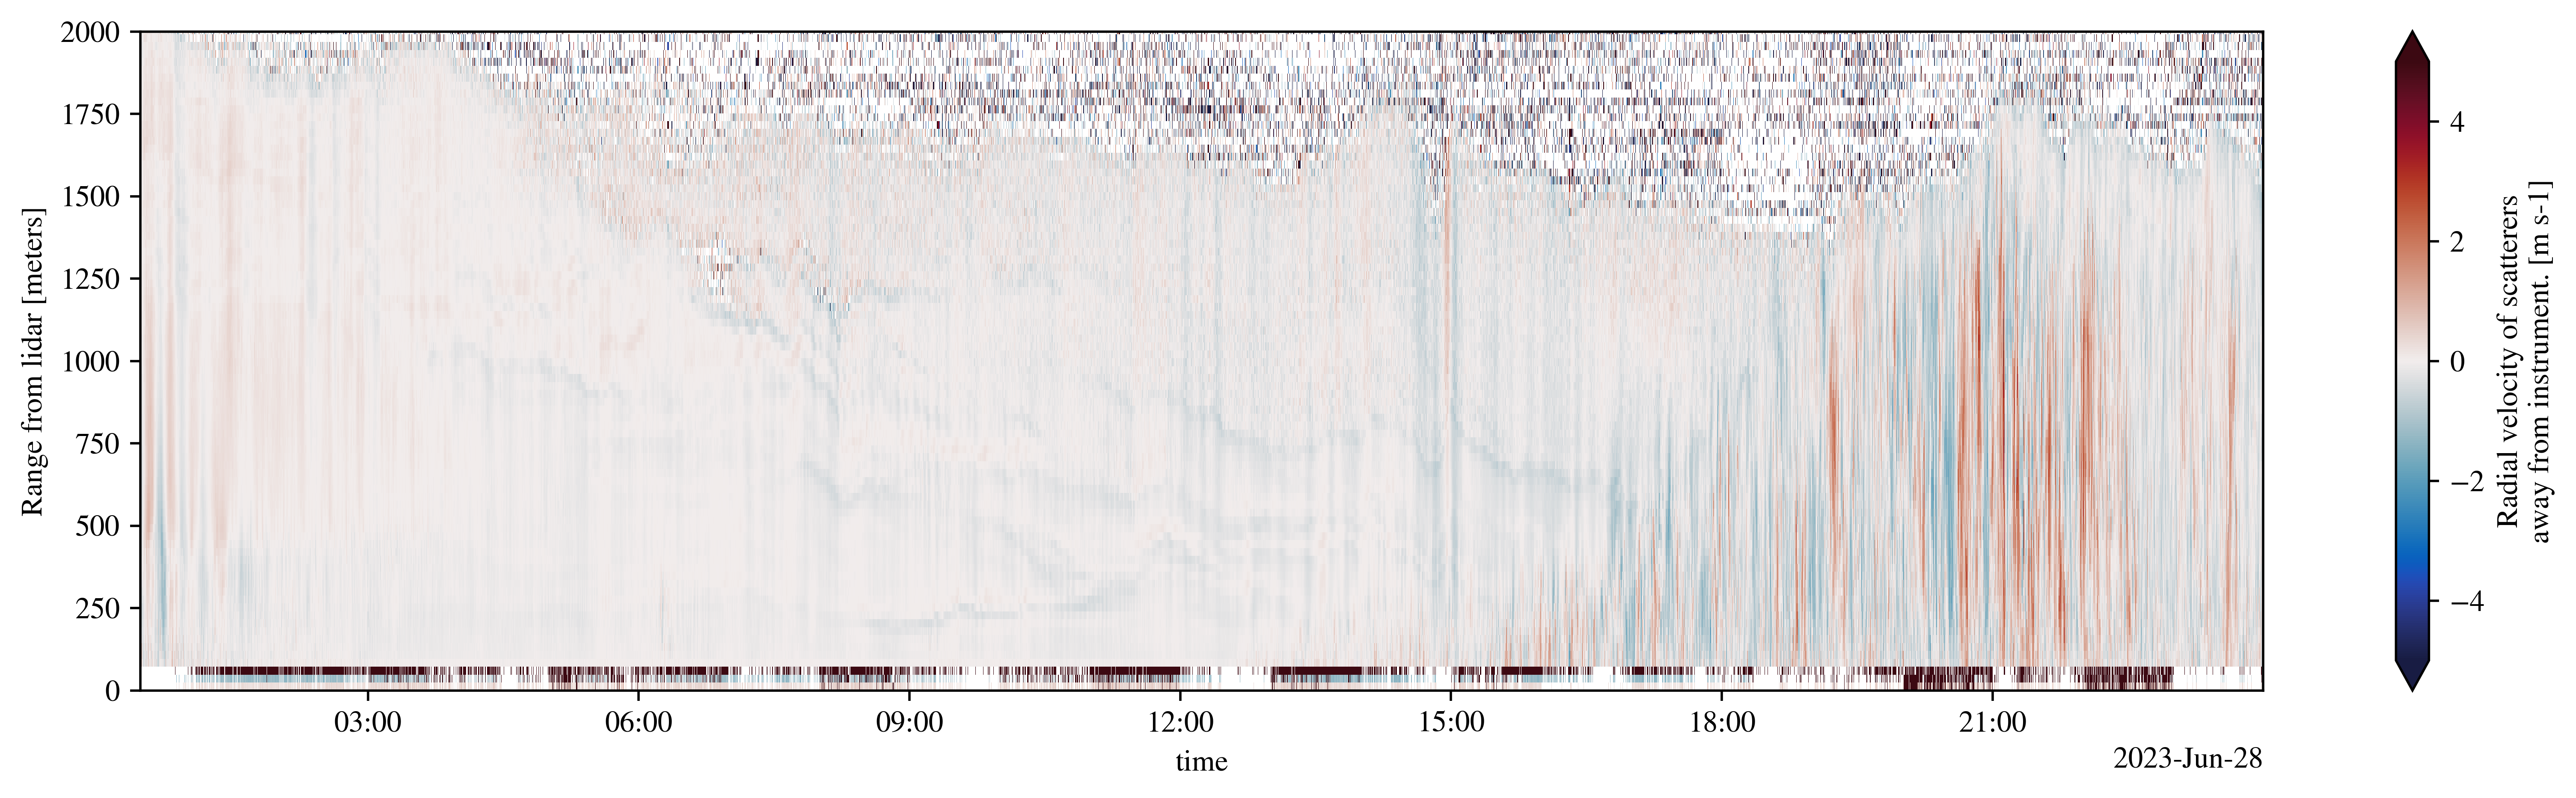

In [6]:
#define filter by SNR (SNR = Intensity - 1)
filt = lidar_stare["intensity"] > 1.008
#make figure
fig = plt.figure(figsize=(16, 4),dpi=500)
lidar_stare["radial_velocity"].T.where(filt).plot(cmap='balance', vmin=-5, vmax=5)
plt.ylim([height_low, height_high])
plt.xlim([lidar_stare['time'].values[3000], lidar_stare['time'].values[-1]])
fig.savefig('pbl_pure_rad_0628.png')

In [7]:
#select data that meet filter creteria, then calculate variance
lidar_stare = get_velocity_variance(lidar_stare.where(filt), window=(1800, 1))

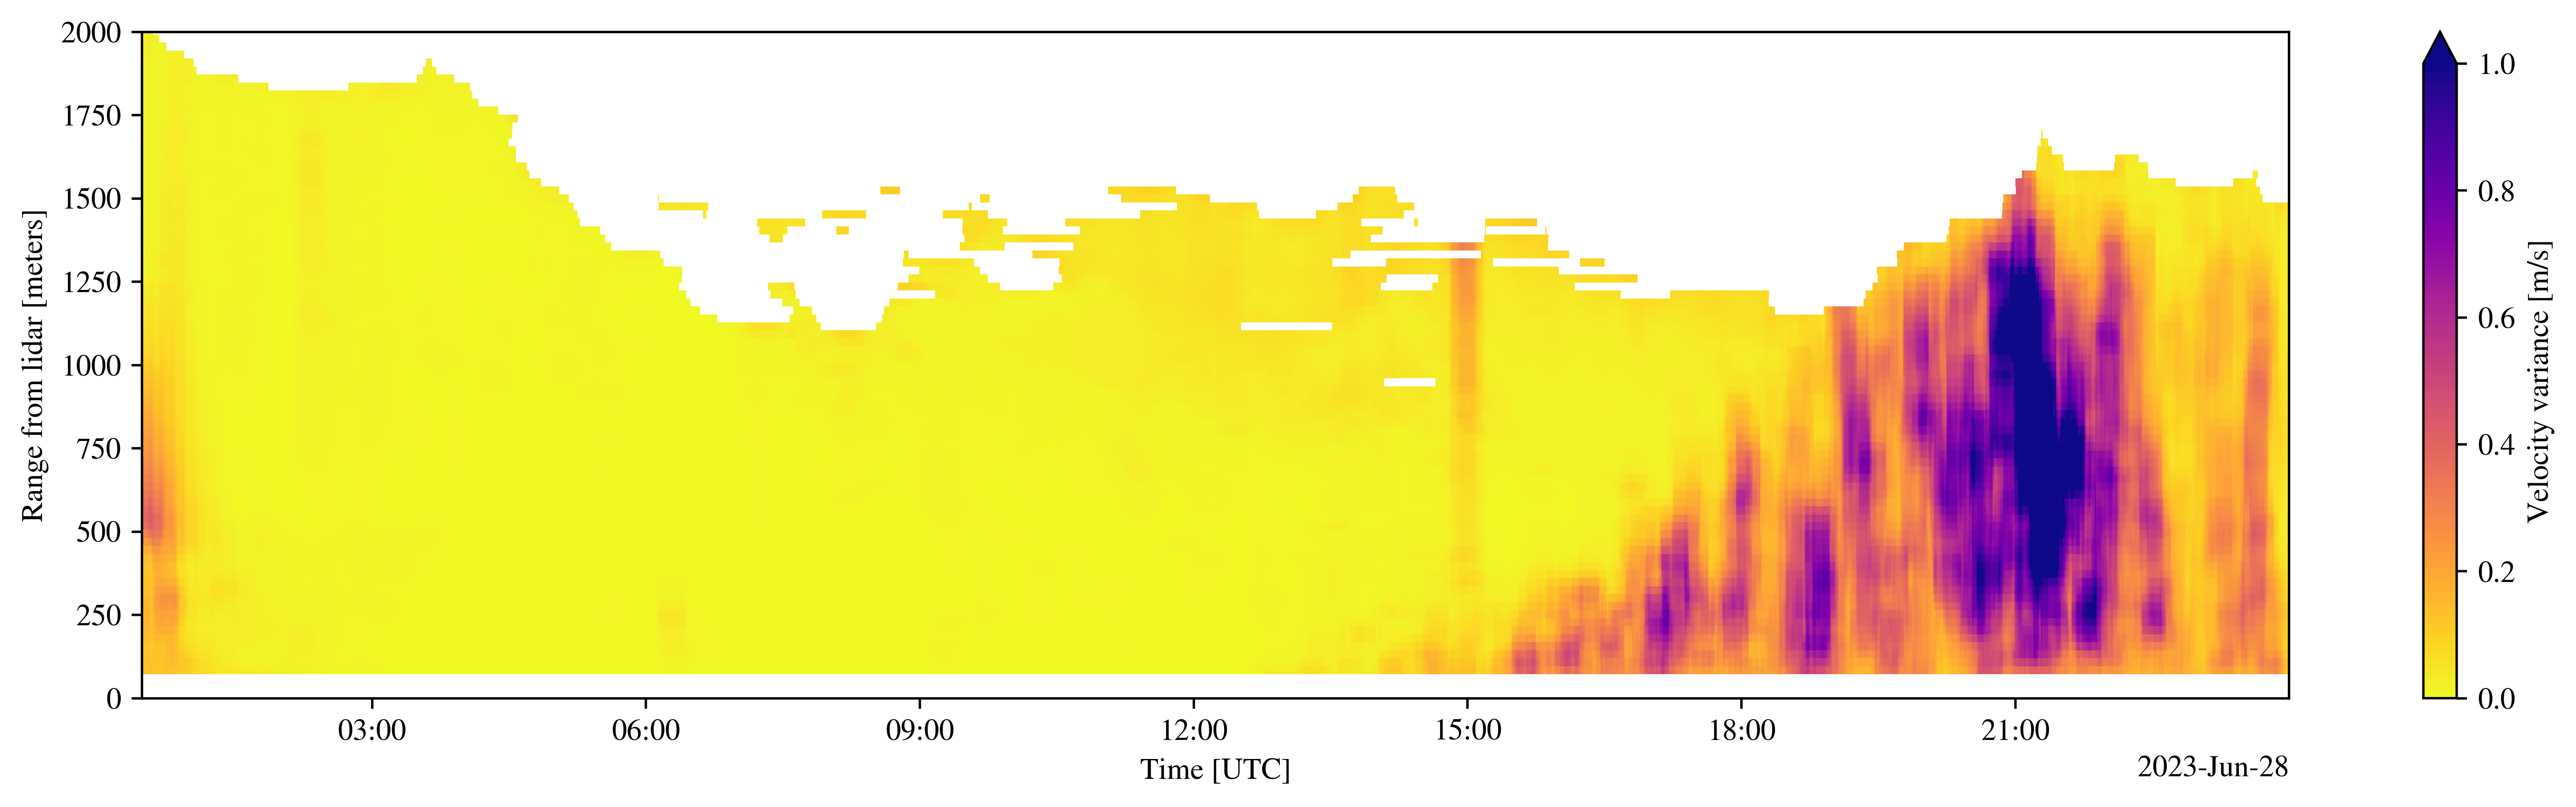

In [8]:
#create plot of variance
fig = plt.figure(figsize=(16, 4), dpi=500)
lidar_stare["velocity_variance"].T.plot(vmin=0,vmax=1, cmap='plasma_r',
                                       cbar_kwargs=dict(label="Velocity variance [m/s]"))
plt.ylim([height_low, height_high])
plt.xlabel('Time [UTC]')
plt.xlim([lidar_stare['time'].values[3000], lidar_stare['time'].values[-1]])
#IMPORTANT save an image of the figure created, change name for each run to avoid overwriting images
fig.savefig('pbl_intensity_0628.png')

In [9]:
#after making initial plots now go on to analyse the image and extract the boundary layer

In [10]:
#import OpenCV and imutils
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2

In [11]:
#read in image of the plot
#IMPORTANT change file name to same as earlier variance plot
image = cv2.imread("pbl_intensity_0628.png")
#OpenCV defines colors using BGR, the following line corrects your RGB image for this
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

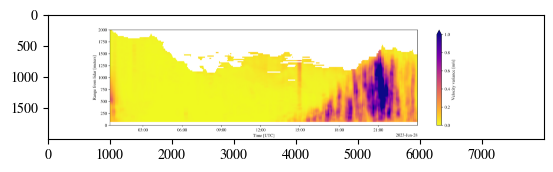

In [12]:
#check that the plot is read-in correctly
plt.imshow(image)
plt.show()

In [13]:
#create an edge map of the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 50, 200, 255)

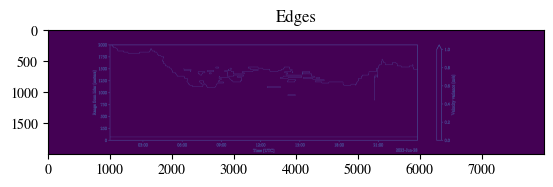

In [14]:
#plot edge map
plt.imshow(edged)
plt.title('Edges')
plt.show()

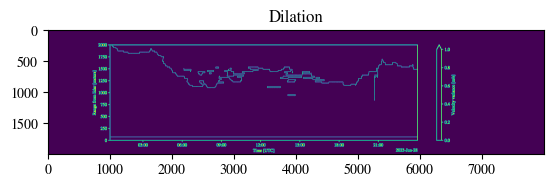

In [15]:
#you can perform a dilation transform to increase edge thickness to improve visibility
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(edged,kernel,iterations = 1)
plt.imshow(dilation)
plt.title('Dilation')
plt.show()

In [16]:
#Sort contours found in the Canny edge image in descending size order
contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
plotEdge = None
#loop over all edge map contours
for cont in contours:
	#approximate the contour
	acurve = cv2.arcLength(cont, True)
	approx = cv2.approxPolyDP(cont, 0.01 * acurve, True) 
	#look for contour with four vertices to isolate colormesh grid
	if len(approx) == 4:
		plotEdge = approx
		break

In [17]:
# extract the colormesh grid inside the contour
warped = four_point_transform(gray, plotEdge.reshape(4, 2))
output = four_point_transform(image, plotEdge.reshape(4, 2))

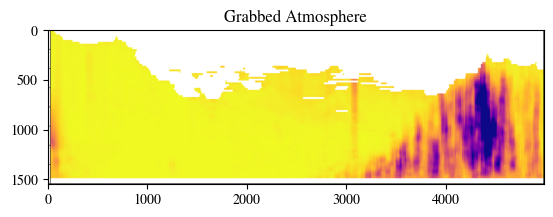

In [18]:
#plot the isolated colormesh grid
plt.imshow(output)
plt.title('Grabbed Atmosphere')
plt.show()

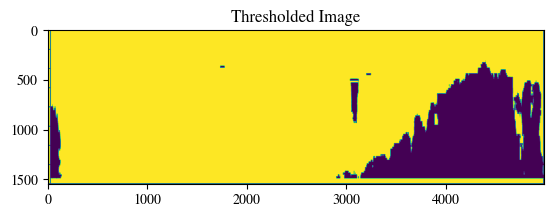

In [19]:
# threshold the colormesh plot of variance
thresh = cv2.threshold(warped,160,255,cv2.THRESH_BINARY)[1]
plt.imshow(thresh)
plt.title('Thresholded Image')
plt.show()

In [20]:
#select contourrs from thresholded boundary condition image
thresh_bound = cv2.Canny(thresh, 50, 200)

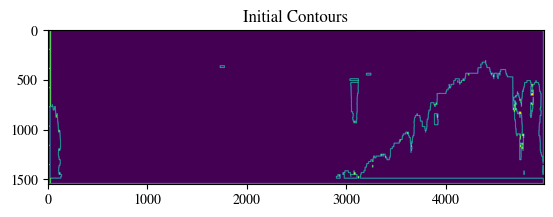

In [21]:
kernel = np.ones((5,5),np.uint8)
thresh_bound_thick = cv2.dilate(thresh_bound,kernel,iterations = 1)
plt.imshow(thresh_bound_thick)
plt.title('Initial Contours')
plt.show()

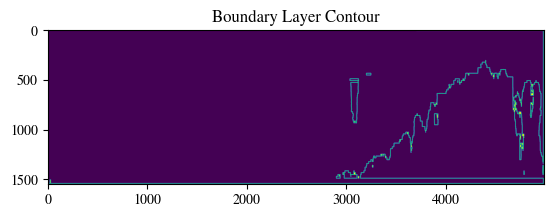

In [22]:
final_bound = thresh_bound_thick.copy()
#mask out nighttime, can be adjusted by redefining blank region
blank_rec = np.zeros((1500,2100), dtype=int)
final_bound[0:1500,0:2100] = blank_rec
#plot the boundary layer contour
plt.imshow(final_bound)
plt.title('Boundary Layer Contour')
plt.show()

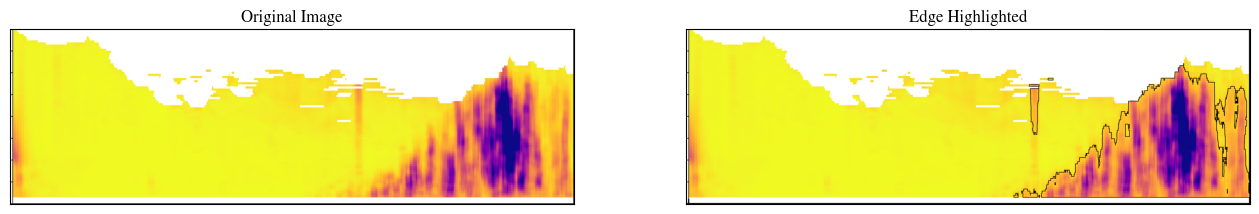

In [23]:
#dupicate the output to keep original and have one version with overlay contour
output2 = output.copy()
output2[final_bound == 255] = [0, 0, 0]  # turn edges to black

#compare colormesh grid with and without boundary layer edge highlighted
fig = plt.figure(figsize = (16,4))
plt.subplot(121),plt.imshow(output)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(output2)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

In [24]:
#find the dimensions of the colormesh grid
pulled_dims = output2.shape
pulled_dims

(1545, 4987, 3)

In [25]:
#overlay extracted boundary layer back onto full plot
#this method  is super janky. I can't recommend it. Just seems to be the best way to get the exact contour back onto the original plot
image_copy = image.copy()
image_copy[237:1782,980:5967] = output2

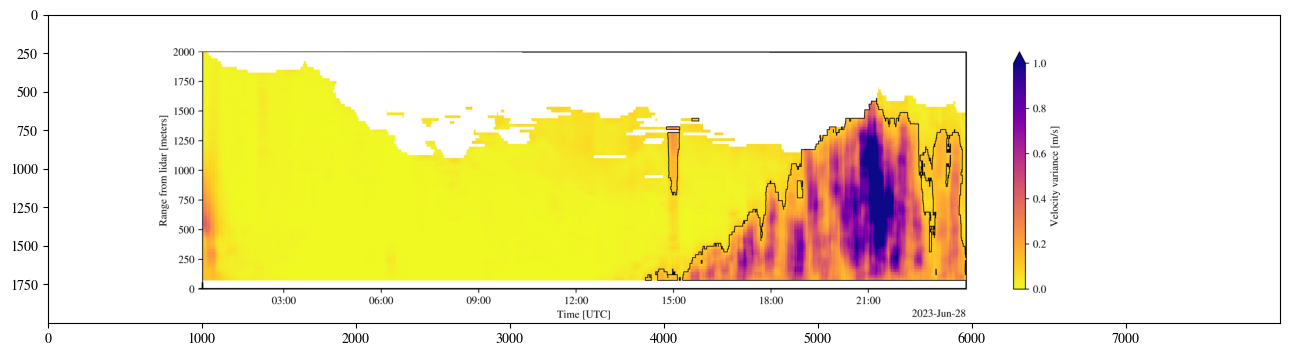

In [26]:
#create final image of figure with boundary layer contour
fig = plt.figure(figsize = (16,4))
plt.imshow(image_copy)
plt.show()
fig.savefig('pbl_overlay1_0628.png')

In [27]:
#extract numerical values for boundary layer height
thresh

array([[255,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [28]:
# unnecesary if you adjust later code, just makes a bit more sense in my head with this orientation
thresh_transpose = thresh.transpose()

In [29]:
#loop over all time to find the height of the boundary layer
#when defining boundary layer height a choice has to be made to count 'from above' or 'from below'
#as there are some times where there are multiple pixels defining the PBLH as the line crosses over itself or eg. you have an isolated rectangle
boundary_layer_heights = []
for i in range(4987):
    for j in range(250,1545):
        #offset in range above is simply to avoid catching edge of the plot, can be adjusted
        if thresh_transpose[i,j] != np.uint8(255):
            boundary_layer_heights.append(j)
            break
        elif j == 1544:
            boundary_layer_heights.append(0)
        else:
            continue

In [30]:
#I decided to count from the top in the above case, so in this step I flip the boundary layer height plot so it's right way up
edge_offset = 1545 * np.ones(len(boundary_layer_heights))
boundary_layer_heights = edge_offset - boundary_layer_heights

In [31]:
pixel_number = np.arange(len(boundary_layer_heights))

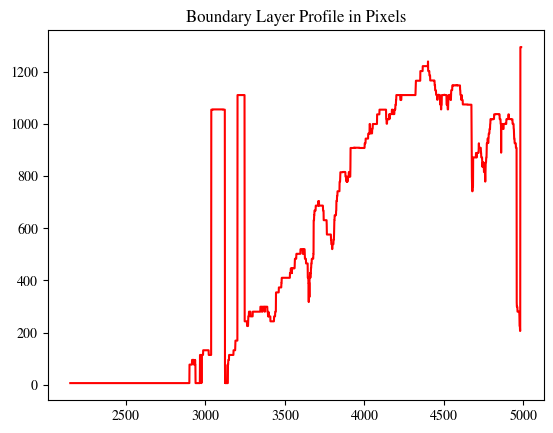

In [32]:
#plot the boundary layer profile in 'pixel units'
plt.plot(pixel_number[2150:], boundary_layer_heights[2150:], 'r')
plt.title('Boundary Layer Profile in Pixels')
plt.show()

In [33]:
#calculate the height and time associated with x and y pixels
pixel_height = (height_high - height_low)/thresh.shape[0]
pixel_time = (lidar_stare['time'].values[-1] - lidar_stare['time'].values[3000])/thresh.shape[1]

In [34]:
#convert heights to metres
boundary_layer_height_m = pixel_height * boundary_layer_heights

In [35]:
#calculate the times from pixels
time_ns = pixel_time * pixel_number

In [36]:
#use start time chosen for lidar plot
start_time = lidar_stare['time'].values[3000]

In [37]:
#can now define a time array for period of interest
time_ofpbl = start_time + time_ns

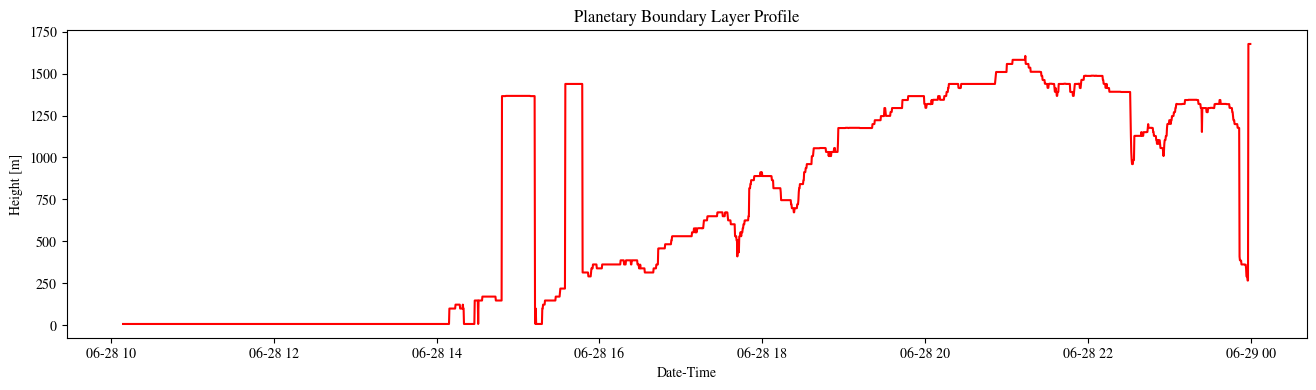

In [38]:
#plot PBL profile, now with physical units
#plotting from around sunrise in the morning
fig = plt.figure(figsize = (16,4))
plt.plot(time_ofpbl[2050:], boundary_layer_height_m[2050:], 'r')
plt.title('Planetary Boundary Layer Profile')
plt.ylabel('Height [m]')
plt.xlabel('Date-Time')
plt.show()
fig.savefig('pblh_0628.png')

In [39]:
#can also calculate the rolling average to smooth out some features
points_to_avg = 10
rolling_avg = []
for i in range(len(boundary_layer_height_m) - points_to_avg + 1):
    window = boundary_layer_height_m[i : i + points_to_avg]
    window_average = sum(window) / points_to_avg
    rolling_avg.append(window_average)

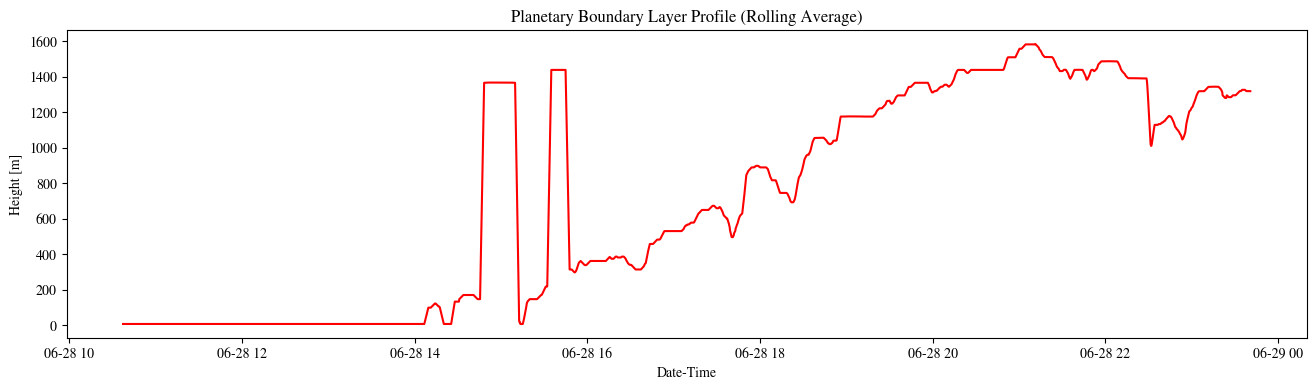

In [40]:
#plot of rolling average profile
fig =  plt.figure(figsize = (16,4))
plt.plot(time_ofpbl[2150:4920],rolling_avg[2150:4920], 'r')
plt.title('Planetary Boundary Layer Profile (Rolling Average)')
plt.ylabel('Height [m]')
plt.xlabel('Date-Time')
plt.show()
fig.savefig('pblh_ravg_0628.png')

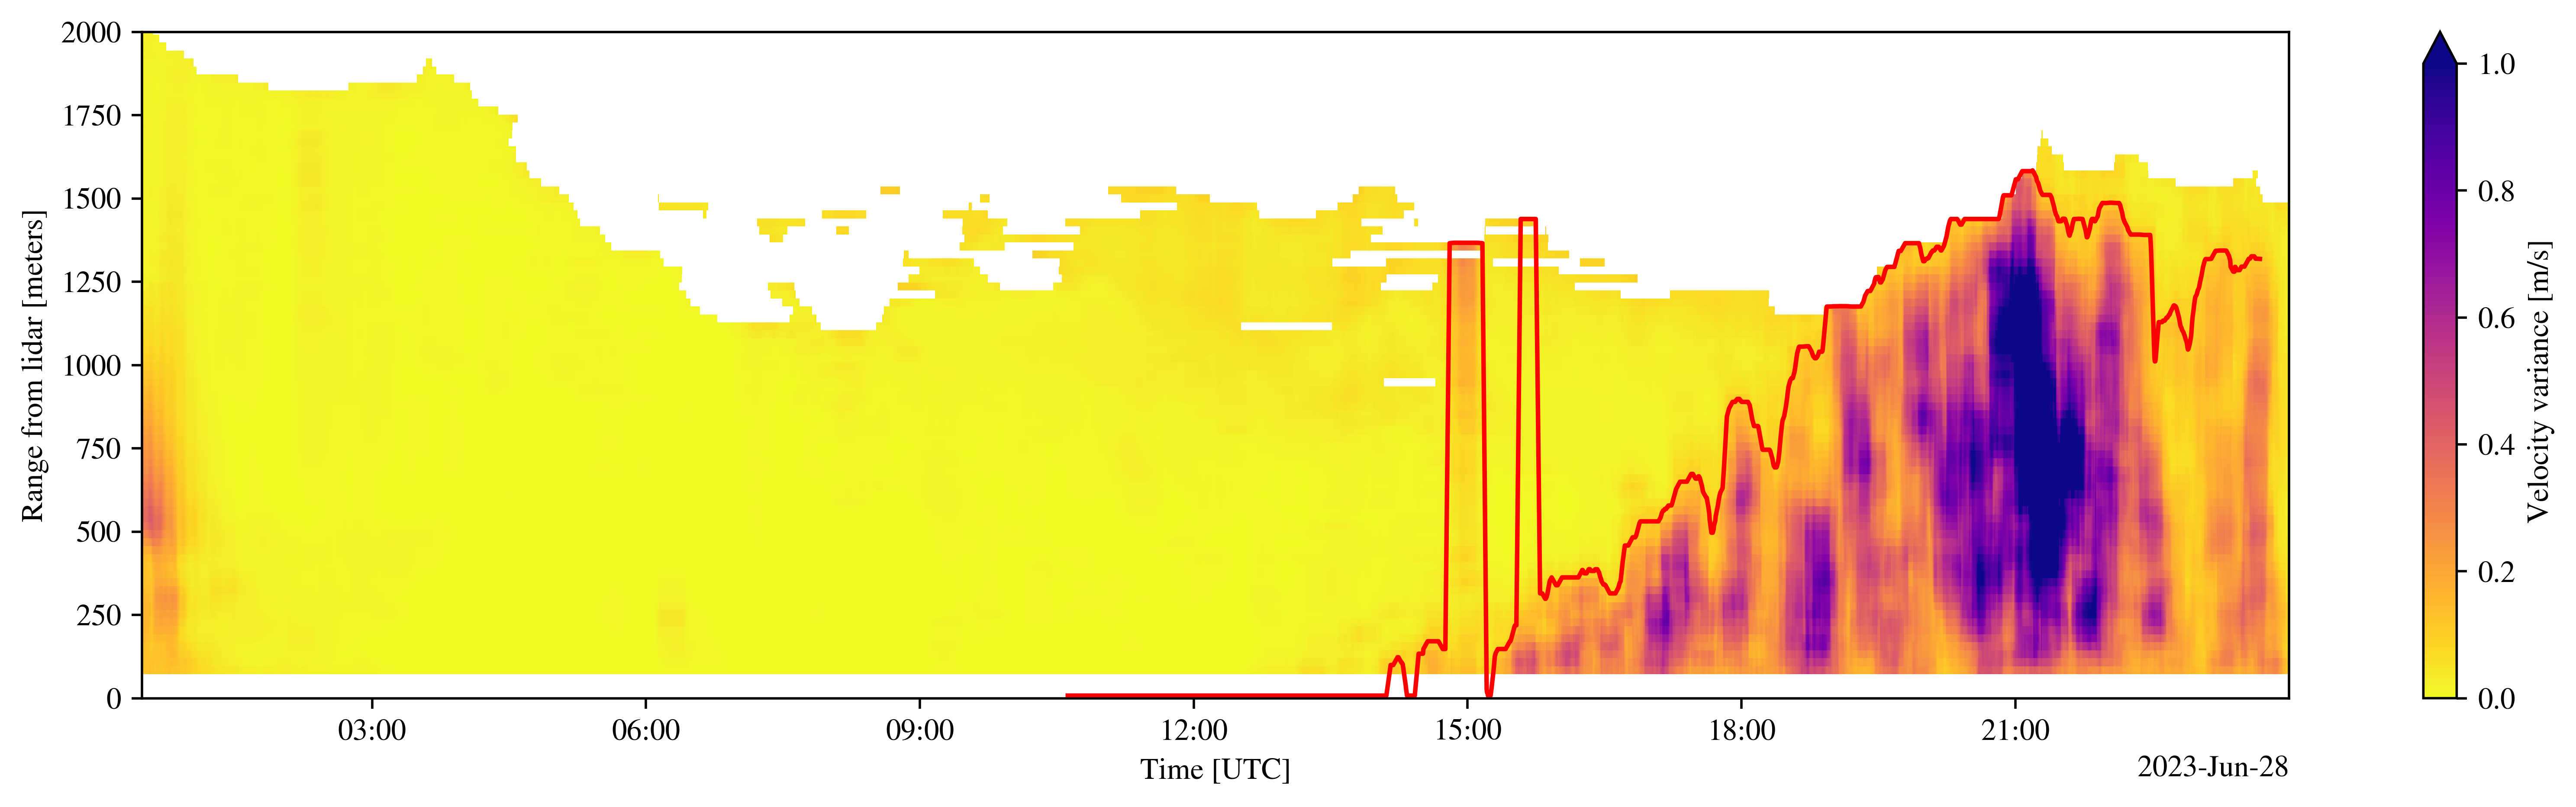

In [41]:
#PBL profile overlayed on velocity variance information
fig = plt.figure(figsize=(16, 4), dpi=500)
lidar_stare["velocity_variance"].T.plot(vmin=0,vmax=1, cmap='plasma_r',
                                       cbar_kwargs=dict(label="Velocity variance [m/s]"))
plt.plot(time_ofpbl[2150:4920],rolling_avg[2150:4920], 'r')
plt.ylim([height_low, height_high])
plt.xlabel('Time [UTC]')
plt.xlim([lidar_stare['time'].values[3000], lidar_stare['time'].values[-1]])
plt.show()
fig.savefig('pbl_line_var_0628.png')

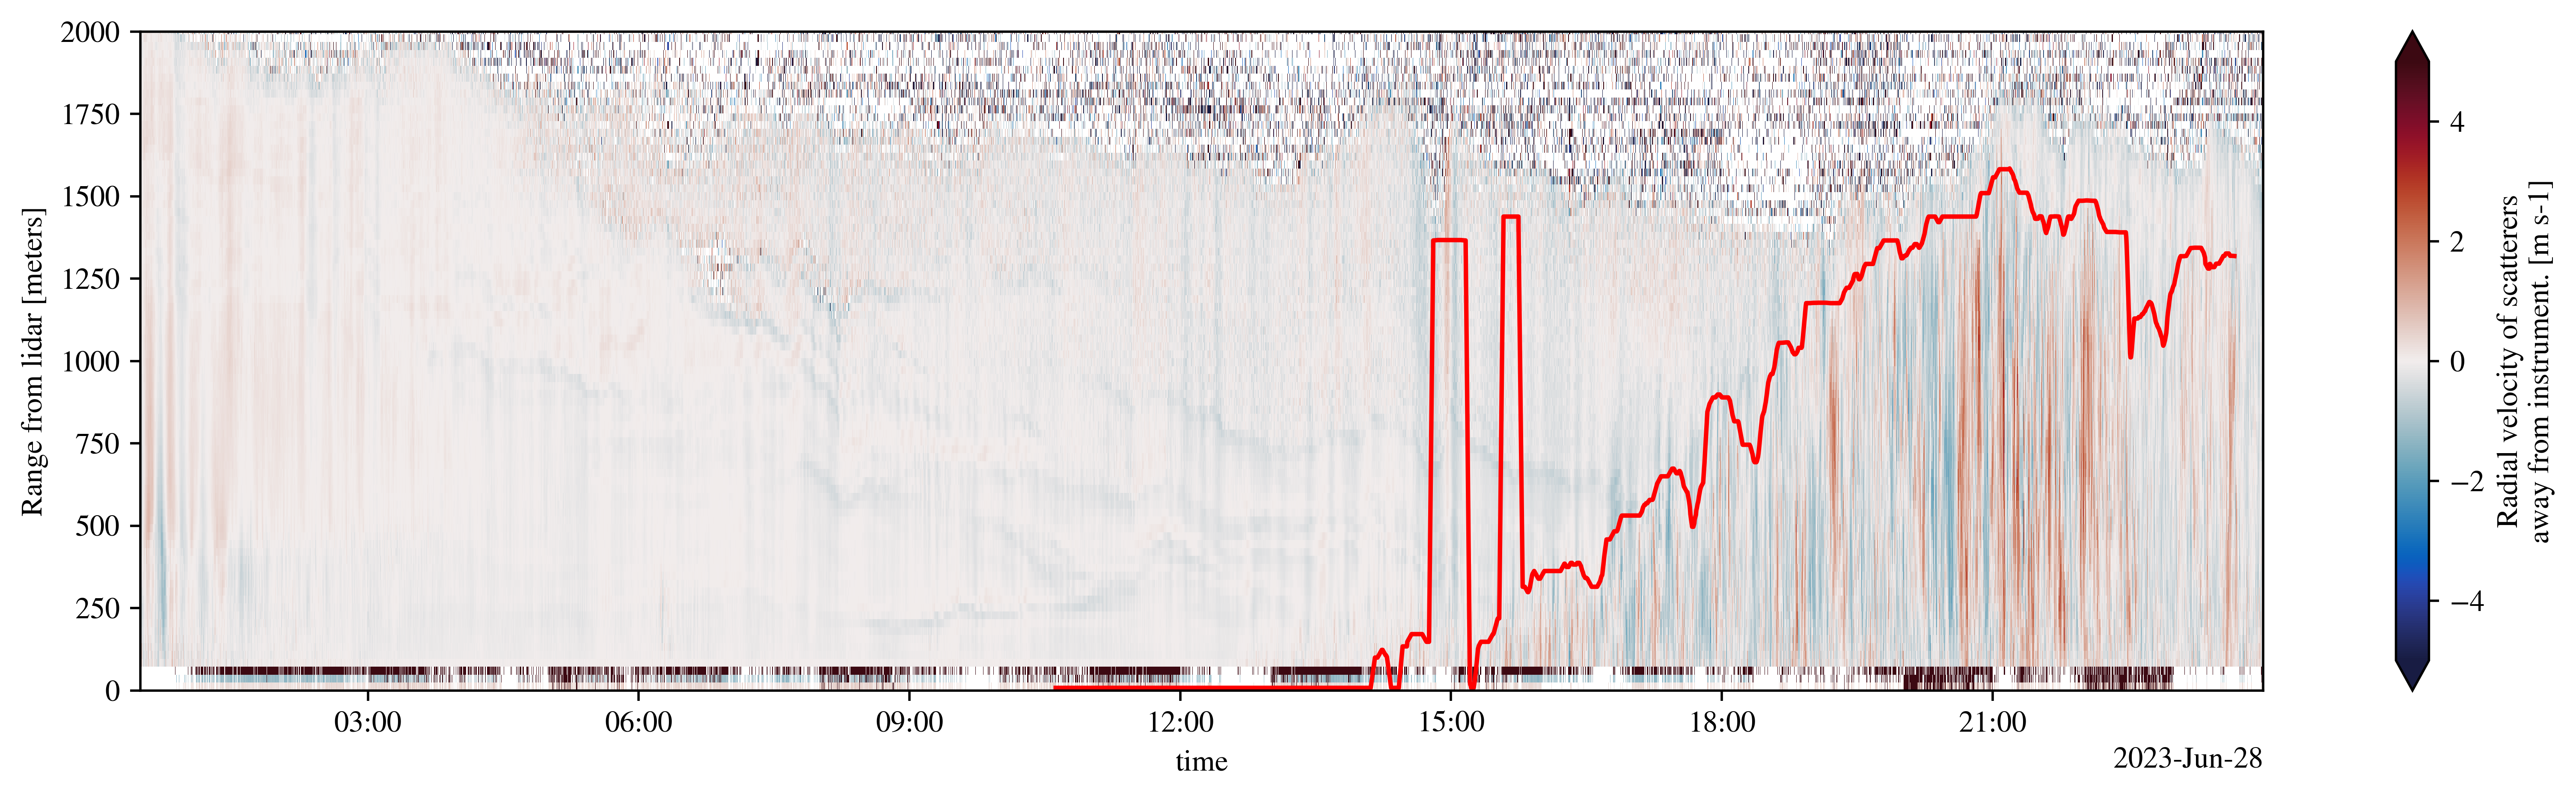

In [42]:
#PBL profile overlayed on radial velocity data
fig = plt.figure(figsize=(16, 4),dpi=500)
lidar_stare["radial_velocity"].T.plot(cmap='balance', vmin=-5, vmax=5)
plt.plot(time_ofpbl[2150:4920],rolling_avg[2150:4920], 'r')
plt.ylim([height_low, height_high])
plt.xlim([lidar_stare['time'].values[3000], lidar_stare['time'].values[-1]])
plt.show()
fig.savefig('pbl_line_dat_0628.png')

In [43]:
#can compare PBL profile with profile extracted from Vaisala CL-61 ceilometer data
#This PBL retrieval utilising the Haar wavelet method was developed by Max Grover!

In [44]:
import pywt

In [45]:
ds = xr.open_dataset("ceilometer/202306/crocus-neiu-ceil-a1-20230628-000000.nc")

ds = ds.sel(range=slice(0, 4_500))

ds = act.corrections.correct_ceil(ds, var_name="beta_att")

ds["beta_att"] = ds.beta_att.where(ds.beta_att >= -6.5)

In [46]:
coeffs = pywt.dwt2(ds.beta_att.values, 'haar')
cA, (cH, cV, cD) = coeffs

resampled_range = ds.range.values[::2]
resampled_time = ds.time.values[::2]

ds["resampled_range"] = resampled_range
ds["resampled_time"] = resampled_time

ds = ds.set_coords(["resampled_range", "resampled_time"])

ds["wavelet_backscatter"] = (("resampled_time", "resampled_range"), cA) 


min_range = ds.wavelet_backscatter.diff("resampled_range").max("resampled_range")
pbl_heights = []
for time in range(len(ds.resampled_time)):
    ds_single_time = ds.isel(resampled_time=time).wavelet_backscatter
    pbl_heights.append(ds_single_time.where(ds_single_time.diff("resampled_range") == min_range.isel(resampled_time=time), drop=True).resampled_range.values[0])

ds["pbl_height"] = (("resampled_time"), pbl_heights)

ds["pbl_height"] = ds.pbl_height.where(ds.pbl_height < 3000)

mask = (ds.linear_depol_ratio > 0) #& (ds.linear_depol_ratio <=0.7)
ldr = ds.linear_depol_ratio#.where(mask)
back = ds.beta_att#.where(mask)

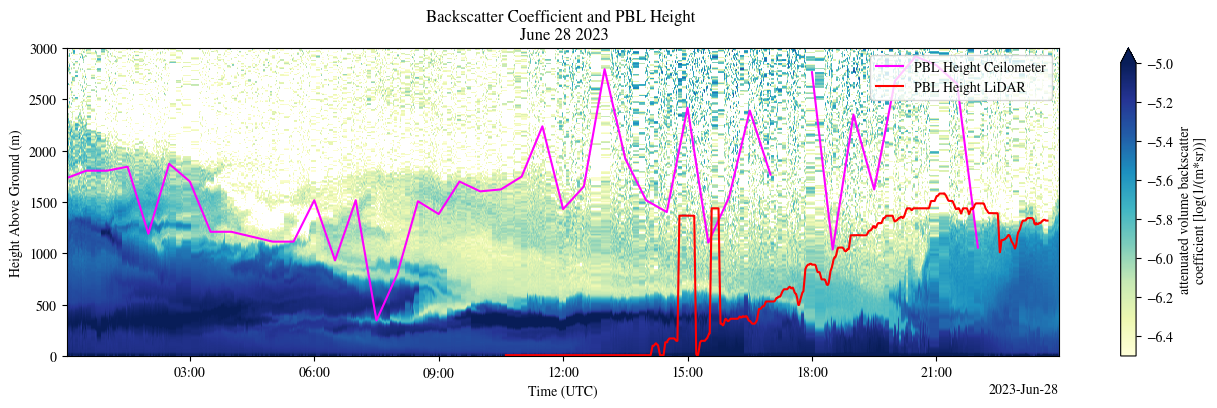

In [47]:
#plot both PBL profiles over some data to compare them
#in this case I have plotted over ceilometer data, but you could just as easily choose to display over LiDAR data
fig = plt.figure(figsize=(16, 4))
back.plot(x='time', vmin=-6.5, vmax=-5, cmap='YlGnBu')
ds.pbl_height.resample(resampled_time='30min').min().plot(color='magenta', label='PBL Height Ceilometer')
plt.plot(time_ofpbl[2150:4920],rolling_avg[2150:4920], color='red', label='PBL Height LiDAR')

plt.ylim(0, 3000)
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (m)")
plt.xlabel("Time (UTC)")
plt.title("Backscatter Coefficient and PBL Height \n June 28 2023")
plt.show()
fig.savefig('pblh_compare_0628.png')

In [48]:
#APPENDIX A
#OPENCV COUNTOUR OVER RADIAL VELOCITY DATA
#A bit of code to plot the PBL contour found with Open CV over the radial velocity data
#This is again a very janky method but works well for seeing features that have been grabbed outside of the main PBL contour, and was useful as a cross-check for ensuring scaling was correct

In [49]:
#repeat similar process to overlay boundary layer edge onto plot of LiDAR vertical velocity
image_raw = cv2.imread('pbl_pure_rad_0628.png')
image_raw = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
image_raw2 = image_raw.copy()

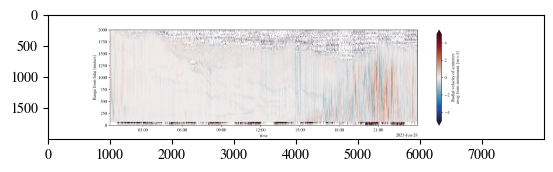

In [50]:
plt.imshow(image_raw)
plt.show()

In [51]:
output2 = four_point_transform(image_raw, plotEdge.reshape(4, 2))

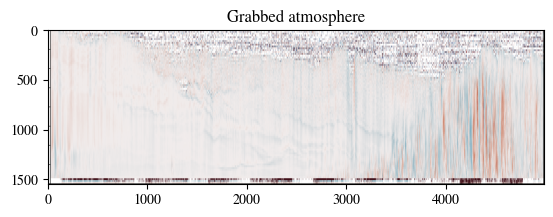

In [52]:
from matplotlib import pyplot as plt
plt.imshow(output2)
plt.title('Grabbed atmosphere')
plt.show()

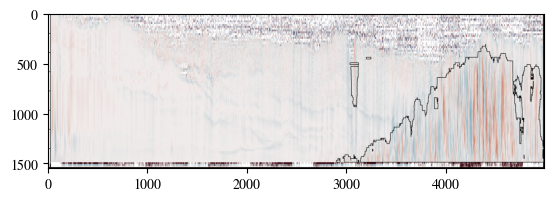

In [53]:
#overlay boundary layer contour onto LiDAR velocity plot
output3 = output2.copy()
output3[final_bound == 255] = [0, 0, 0]  # turn edges to black
plt.imshow(output3)
plt.show()

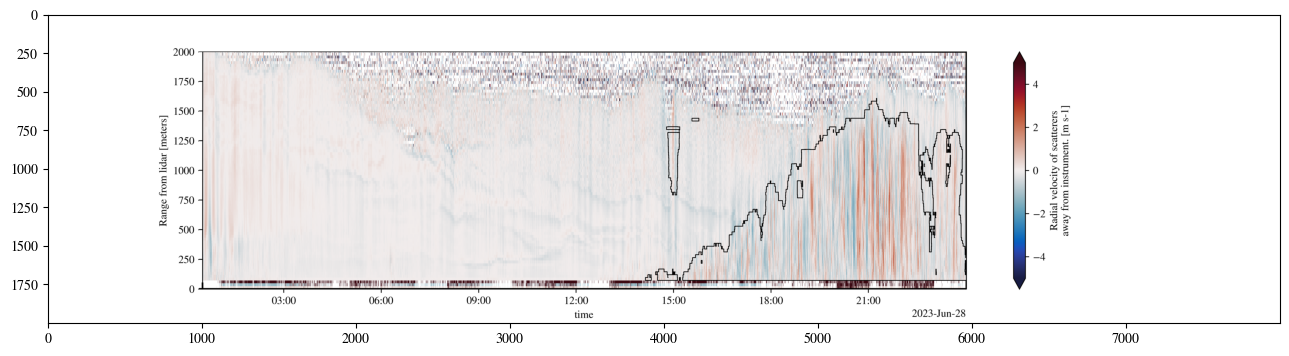

In [54]:
#make final full plot with boundary layer contour overlaid on radial velocity plot
image_copy2 = image_raw.copy()
image_copy2[237:1782,980:5967] = output3
fig = plt.figure(figsize = (16,4))
plt.imshow(image_copy2)
plt.show()
fig.savefig('pbl_overlay2_0628.png')